In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import glob
import logging
from pathlib import Path

import numpy as np
import pandas as pd
import numpyro

from hb_mep.config import HBMepConfig
from hb_mep.data_access import DataClass
from hb_mep.models.rats.rectified_logistic import RectifiedLogistic
from hb_mep.utils import plot

numpyro.set_platform("cpu")
numpyro.set_host_device_count(12)
numpyro.enable_x64()

PARENT_PATH = Path(os.getcwd()).parent.parent.absolute()
FORMAT = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)

#### Load config

In [3]:
config = HBMepConfig()
config.CURRENT_PATH = PARENT_PATH


#### Load data and preprocess

In [4]:
data = DataClass(config)

fpath = glob.glob(os.path.join(data.data_path, "rats_data/amap*/*/*.csv"))
df = None

for f in fpath:
    temp = pd.read_csv(f)

    participant = f.split("/")[-3]
    temp["participant"] = participant

    temp = temp[temp.channel1_segment.isna()].copy()

    temp["method"] = temp.channel2_laterality

    if df is None:
        df = temp.copy()
    else:
        df = pd.concat([df, temp], ignore_index=True).copy()

df.reset_index(drop=True, inplace=True)

df, encoder_dict = data.build(df)

df = df[df.participant.isin([0])].copy()
# df = df[df.compound_position.isin([0, 1, 2, 5])].copy()
df = df[df.compound_position.isin([2, 5])].copy()
df.reset_index(drop=True, inplace=True)

2023-05-23 16:14:39,928 - hb_mep.data_access.core - INFO - Processing data ...
2023-05-23 16:14:39,982 - hb_mep.utils.utils - INFO - func:preprocess took: 0.05 sec
2023-05-23 16:14:39,983 - hb_mep.utils.utils - INFO - func:build took: 0.06 sec


In [5]:
# df.compound_position.unique()

#### Plot data

In [6]:
# plot(df, encoder_dict=encoder_dict);

#### Initialize model

In [7]:
model = RectifiedLogistic(config)

#### Run MCMC inference

In [8]:
mcmc, posterior_samples = model.run_inference(df=df)

2023-05-23 16:14:40,450 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
2023-05-23 16:14:40,450 - jax._src.xla_bridge - INFO - Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-05-23 16:14:40,451 - jax._src.xla_bridge - INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-05-23 16:14:40,451 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
2023-05-23 16:14:40,451 - jax._src.xla_bridge - INFO - Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
2023-05-23 16:14:40,486 - hb_mep.models.rats.rectified_logistic - INFO - Running inference with Rec

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-05-23 16:18:08,795 - hb_mep.utils.utils - INFO - func:run_inference took: 3 min and 28.35 sec


#### Diagnostics

In [9]:
mcmc.print_summary()


                           mean       std    median      5.0%     95.0%     n_eff     r_hat
             a[0,0,0]     13.38     24.31      4.04      0.14     33.84      7.03      1.76
             a[0,1,0]     44.91     40.04     44.49      0.74     99.01      3.31      2.43
             a[1,0,0]      4.58     12.46      1.25      0.01      6.19     14.58      1.26
             a[1,1,0]      2.23      1.90      1.55      0.34      4.64      5.45      1.86
            a_mean[0]      9.25     16.18      1.87      0.11     31.68      7.62      1.66
           a_scale[0]     19.82     16.87     17.42      1.92     45.35      3.36      2.39
             b[0,0,0]      0.06      0.07      0.02      0.00      0.17      2.19      4.09
             b[0,1,0]      0.02      0.02      0.01      0.00      0.05      2.60      2.46
             b[1,0,0]      0.08      0.10      0.03      0.00      0.27      2.25      3.43
             b[1,1,0]      0.00      0.00      0.00      0.00      0.01      2.

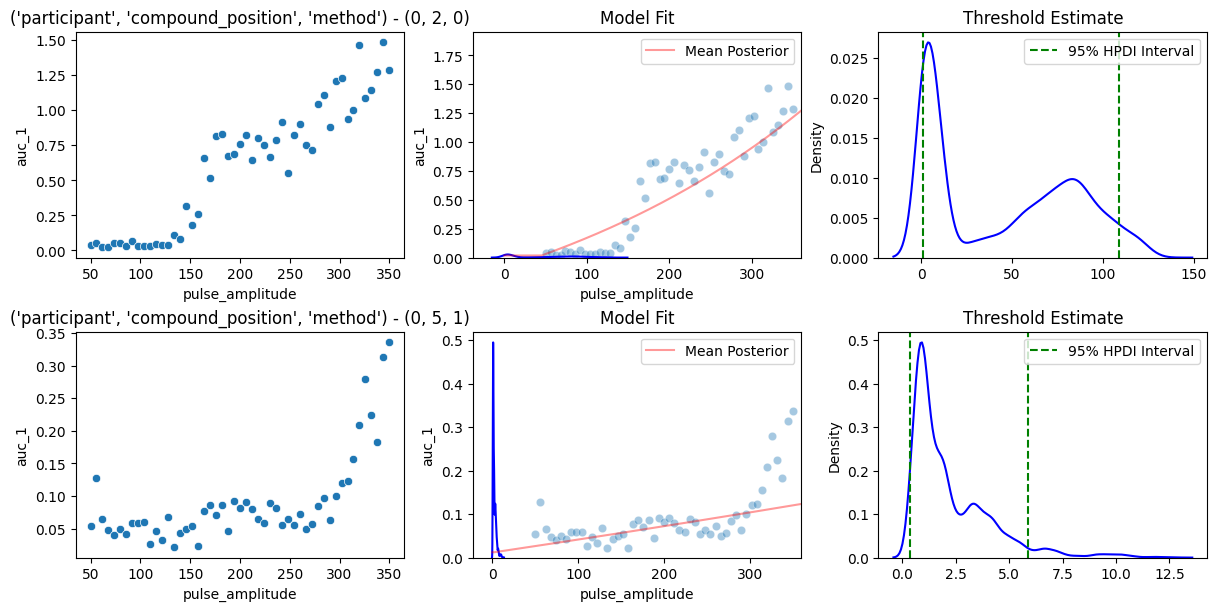

In [10]:
model.plot(df=df, posterior_samples=posterior_samples);